In [92]:
import torch, pyworld as pw, librosa, numpy as np, matplotlib.pyplot as plt
from pathlib import Path; from functools import partial
from torch import tensor

In [85]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
np.set_printoptions(precision=2, linewidth=140, suppress=True)

In [6]:
path = Path("../data/LJSpeech-1.1/")

sample_rate = 22050
n_fft = 1024
hop_length = 256 
n_bins = 80

In [12]:
sample, _ = librosa.load(path/"wavs/LJ001-0001.wav", sr=sample_rate); sample.shape

(212893,)

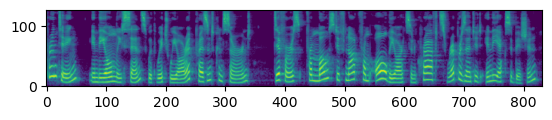

In [17]:
mels = librosa.feature.melspectrogram(y=sample, sr=sample_rate, n_fft=n_fft, 
                                     hop_length=hop_length)
plt.imshow(librosa.power_to_db(mels), origin='lower');

## Energy

In [101]:
stft = librosa.stft(y=sample, n_fft=n_fft, hop_length=hop_length)

In [115]:
magnitude, phase = librosa.magphase(stft)
amplitude = np.abs(stft)

In [116]:
energy_t = np.sqrt(np.sum(np.square(amplitude), axis=0)); energy[:10]

array([ 0.08,  4.  ,  8.34,  5.16, 10.3 , 49.89, 75.11, 74.37, 73.91, 78.13], dtype=float32)

In [117]:
energy = np.linalg.norm(magnitude, axis=0); energy[:10]

array([ 0.08,  4.  ,  8.34,  5.16, 10.3 , 49.89, 75.11, 74.37, 73.91, 78.13], dtype=float32)

In [120]:
(energy == energy_t).all()

True

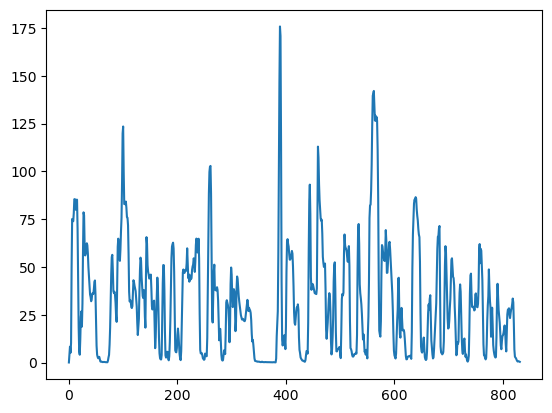

In [122]:
plt.plot(energy);

### Linear Quantization

In [131]:
num_levels = 256

In [66]:
min_val, max_val = energy.min(), energy.max(); min_val, max_val

(0.08237383, 175.74081)

In [134]:
levels = np.linspace(min_val, max_val, num_levels); levels.shape

(256,)

In [162]:
quantized_vals = np.zeros_like(energy, dtype=int)

for i, val in enumerate(energy):
    quantized_vals[i] = np.argmin(np.abs(levels - val))

In [163]:
quantized_vals.max(), quantized_vals.min()

(255, 0)

In [161]:
quantized_vals_t = np.digitize(energy, levels) - 1

### Function

In [123]:
def extract_energy(wav, sr, n_fft, hop_length):
    stft = librosa.stft(y=wav, n_fft=n_fft, hop_length=hop_length)
    amplitude = np.abs(stft)
    energy = np.linalg.norm(amplitude, axis=0)
    return energy

In [125]:
(extract_energy(sample, sample_rate, n_fft, hop_length) == energy).all()

True

In [168]:
def linear_quantization(vals, n_levels, min_v=None, max_v=None):
    if min_v is None: min_v = np.min(vals)
    if max_v is None: max_v = np.max(vals)
        
    levels = np.linspace(min_v, max_v, n_levels)
    
    quantized_vals = np.digitize(energy, levels) - 1
    return quantized_vals

In [173]:
linear_quantization(energy, 256);

## Pitch

In [177]:
f0, t = pw.dio(sample.astype(np.float64), fs=sample_rate, 
               frame_period=hop_length/sample_rate * 1000)

In [179]:
pitch = pw.stonemask(sample.astype(np.float64), f0, t, fs=sample_rate); pitch.shape

(832,)

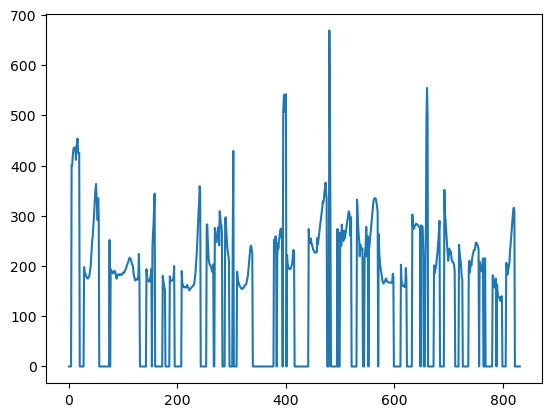

In [181]:
plt.plot(pitch);

### Quantization